In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
import time
import sys
import pandas as pd
import tensorflow as tf
import skimage as ski

from scipy.optimize import minimize

https://www.researchgate.net/publication/347462953_Interpretable_and_effective_hashing_via_Bernoulli_variational_auto-encoders

In [4]:

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [5]:
train_dataset2=np.load('../input/metagrating/dataset.npy')
train_dataset2=np.reshape(train_dataset2,(-1,1,256,128))
train_dataset2=torch.from_numpy(train_dataset2)



In [6]:
training_dataset=T.functional.resize(train_dataset2[0,:,:,:],50)
for i in range(1,len(train_dataset2)):
    training_dataset=torch.cat((training_dataset,T.functional.resize(train_dataset2[i,:,:,:],50)))


for i in training_dataset:
    i[i<0.1]=0
    i[i>0.1]=1
    i[i==0.1]=1
    
train_dataset2=torch.flatten(training_dataset,start_dim=1)

In [7]:
perm = torch.randperm(train_dataset2.size(0))
idx = perm[:100]
samples = train_dataset2[idx]

In [8]:
samples[11]

tensor([1., 1., 1.,  ..., 1., 1., 1.])

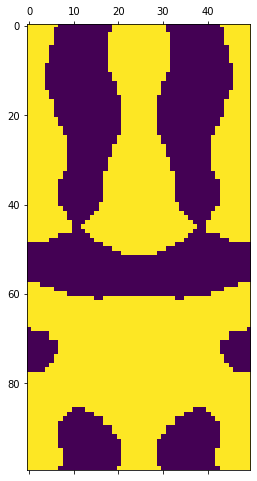

In [9]:
plt.matshow(training_dataset[12])

In [10]:
#train_dataset_val=train_dataset2[800:1000]
train_dataset2=train_dataset2[0:10]


In [11]:
np.shape(train_dataset2)

torch.Size([10, 5000])

In [12]:
train_dataset2.size()

torch.Size([10, 5000])

In [13]:
train_dataset2=np.genfromtxt('../input/mnist-in-csv/mnist_train.csv',delimiter=',')
train_dataset2=train_dataset2[1:1000,1:]
train_dataset2=np.where(train_dataset2>0.5,1,train_dataset2)
train_dataset2=np.where(train_dataset2<0.5,0,train_dataset2)
train_dataset2=torch.from_numpy(train_dataset2)

In [14]:
train_dataset_val=train_dataset2[800:999]
train_dataset2=train_dataset2[0:50]

In [15]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

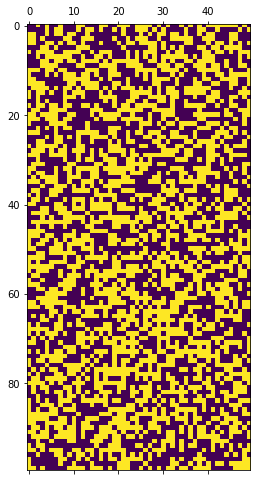

In [16]:
a = torch.ones(100,50)*0.5
b=torch.bernoulli(a)
plt.matshow(b)

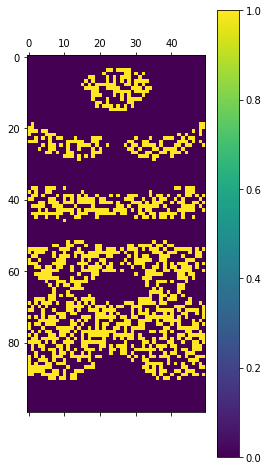

In [17]:
plt.matshow(training_dataset[np.random.randint(1000)]*b)
plt.colorbar()

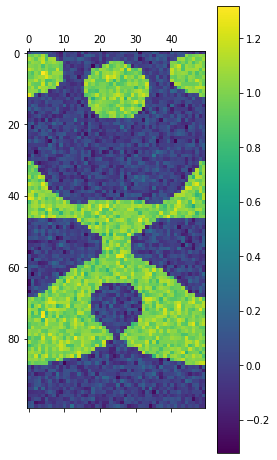

In [18]:
std=0.1
plt.matshow(training_dataset[np.random.randint(1000)]+torch.normal(0,std,(100,50)))
plt.colorbar()

In [19]:
torch.normal(0,std,(100,50))

tensor([[-0.1249, -0.0077,  0.0243,  ...,  0.0673, -0.1068,  0.0717],
        [ 0.0993,  0.0206,  0.0108,  ...,  0.1280, -0.0911,  0.0955],
        [ 0.0735,  0.0359,  0.2174,  ...,  0.0625,  0.0817,  0.1349],
        ...,
        [ 0.0472,  0.1515,  0.0311,  ..., -0.0621,  0.0144,  0.0109],
        [-0.1182, -0.1264,  0.1458,  ...,  0.2120, -0.0995, -0.0209],
        [-0.0470, -0.1854, -0.0583,  ..., -0.0400,  0.1159,  0.0401]])

(<matplotlib.colorbar.Colorbar at 0x77fed93e9110>, tensor(0.))

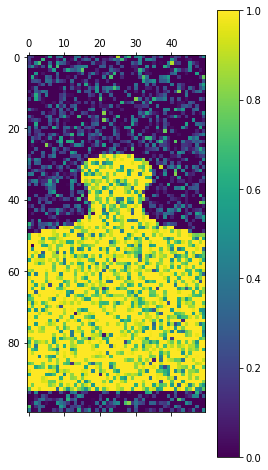

In [20]:
std=0.3
noisy_image=torch.clamp(training_dataset[np.random.randint(1000)]+torch.normal(0,std,(100,50)),0,1)
plt.matshow(noisy_image)
plt.colorbar(),torch.min(noisy_image)

In [21]:
#for i in train_dataset2[100:104]:
#    plt.matshow(np.reshape(i.cpu().detach().numpy(),(256,128)))

In [22]:
##FOR IMPLEMENTING STRAIGHT THROUGH BVAE

class binarization(torch.autograd.Function):
    
    @staticmethod
    
    def forward(self,input):
        a=input.clone()
        a[a>0.0]=torch.tensor([1-(1e-5)])
        a[a<0.0]=torch.tensor([-1+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_input
    
class binarization2(torch.autograd.Function):
    
    @staticmethod
    
    def forward(self,input):
        a=input.clone()
        a[a>0.5]=torch.tensor([1-(1e-5)])
        a[a<0.5]=torch.tensor([0+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_input
        
        
        

In [47]:
class bVAE(nn.Module):
  def __init__(self,latent_dim):
    super(bVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,1000),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),
        
        nn.Linear(1000,500),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(500),
        nn.Dropout(p=0.3),

        nn.Linear(500,200),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(200),
        nn.Dropout(p=0.3),

        nn.Linear(200,latent_dim),
        nn.Sigmoid()
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,200),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(200),
        nn.Dropout(p=0.3),

        nn.Linear(200,500),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(500),
        nn.Dropout(p=0.3),
        
        nn.Linear(500,1000),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(1000,input_size),
        nn.Sigmoid()
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=2*self.gumbel_reparam(e,lambd)-1
    b=binarization.apply(g)
    d=self.decode(g)
    d2=self.gumbel_reparam(d,0.3)

    return d2,b,g,e


In [24]:
class CNNbVAE(nn.Module):
  def __init__(self,latent_dim):
    super(CNNbVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,700),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(700,400),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(400,latent_dim),
        nn.Sigmoid()
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,400),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(400,700),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(700,input_size),
        nn.Sigmoid()
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=2*self.gumbel_reparam(e,lambd)-1
    b=binarization.apply(g)
    d=self.decode(b)
    return d,b,g,e

In [65]:
class bVAE(nn.Module):
  def __init__(self,latent_dim):
    super(bVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,512),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(512,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(256,latent_dim),
        nn.Sigmoid()
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(256,512),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(512,input_size),
        nn.Sigmoid()
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=2*self.gumbel_reparam(e,lambd)-1
    b=binarization.apply(g)
    d=self.decode(g)
    d2=self.gumbel_reparam(d,torch.Tensor([0.3]))

    return d2,b,g,e

In [66]:
'''
model=torch.load('/kaggle/input/model2mid2/model_meta_meta_noise100_anneal02_mid2')
input_size=5000
latent_dim=500
LEARNING_RATE=1e-4

num_epochs=2000

lambd=torch.Tensor([0.4])
lambd_min=torch.Tensor([0.4])
lambd_learning_rate=torch.Tensor([3e-5])

model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

'''

"\nmodel=torch.load('/kaggle/input/model2mid2/model_meta_meta_noise100_anneal02_mid2')\ninput_size=5000\nlatent_dim=500\nLEARNING_RATE=1e-4\n\nnum_epochs=2000\n\nlambd=torch.Tensor([0.4])\nlambd_min=torch.Tensor([0.4])\nlambd_learning_rate=torch.Tensor([3e-5])\n\nmodel.to(DEVICE)\n\noptimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  \n\n"

Everytime you call load a pretrained model, want to continue training, make surre that the lambda vallue is where you left it at

In [67]:

input_size=5000#784
latent_dim=500
LEARNING_RATE=1e-3

num_epochs=2000

lambd=torch.Tensor([5.0])
lambd_min=torch.Tensor([0.3])
lambd_learning_rate=torch.Tensor([3e-4])


model=bVAE(latent_dim)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [28]:
#LEARNING_RATE=1e-2

In [29]:
#model.load_state_dict(torch.load('../input/meta-dict2/bVAE_state_dict_meta2'))

In [30]:
#lambd=torch.Tensor([5.0])

In [49]:
c1=1
c2=0

In [50]:
def compute_loss(model,x):
    x_hat,bi,gumbell,a=model(x+torch.rand(x.size()).to(DEVICE))
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=F.mse_loss(x,x_hat)
    #loss=nn.BCELoss()
    
    #reconstruction_loss=loss(x_hat,x)
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a)))
    total_loss=c1*reconstruction_loss+c2*KL_loss
    return total_loss,reconstruction_loss,KL_loss

def compute_loss2(model,x): ### WRONG!!!! CHECK THE AXIS OF KL_LOSS...should be 1
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=torch.mean(F.mse_loss(x,x_hat))
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=0))
    total_loss=c1*reconstruction_loss+c2*KL_loss
    return total_loss,reconstruction_loss,KL_loss


def compute_loss_batch(model,x):
#!!!!!!!!!#### befor runing check x and x1 always
    x=x.float()
    x1=torch.clamp(x+torch.normal(0.0,std,x.size()).to(DEVICE),0,1)
    x_hat,bi,gumbell,a=model(x1*torch.bernoulli(torch.ones(x.size()).to(DEVICE)*b))
    reconstruction_loss=torch.sum(torch.square(x-x_hat),axis=1) ## next instead of sum, make it mean!!!!!!!!
    #reconstruction_loss= F.binary_cross_entropy(x_hat, x)
    '''
    x_hat=torch.clamp(x_hat,min=1e-3,max=1-1e-3)
    reconstruction_loss=-(x*torch.log(x_hat)+(1-x)*torch.log(1-x_hat))
    reconstruction_loss=torch.mean(reconstruction_loss,axis=1)
    '''
    

    KL_loss=latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)

    total_loss=torch.mean(c1*reconstruction_loss+c2*KL_loss)
    return total_loss,torch.mean(reconstruction_loss),torch.mean(KL_loss)

In [51]:
#x=train_dataset2.to(DEVICE)

In [52]:
#x=torch.tensor(1)
#x_hat=torch.tensor(0.0)
#x_hat=torch.clamp(x_hat,min=1e-3,max=1-1e-3)
#x_hat

In [53]:
#reconstruction_loss=-(x*torch.log(x_hat)+(1-x)*torch.log(1-x_hat))

In [54]:
#reconstruction_loss=torch.mean(reconstruction_loss,axis=1)

In [55]:
#reconstruction_loss.size()

In [56]:
#x_hat,y,z,v=model(train_dataset2.to(DEVICE))

In [57]:
#train_dataset2.size()

In [58]:
#x_hat,bi,gumbell,a=model(train_dataset2.to(DEVICE))

In [59]:
#a.size()

In [60]:
#torch.mean(torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)+latent_dim*np.log(2) )

In [61]:
#torch.mean((x_hat-train_dataset2.float()),axis=1).size()

In [62]:
#compute_loss_batch(model,train_dataset2.to(DEVICE))

In [63]:
t=[]
r=[]
k=[]
ll=[]

In [ ]:
c2=0.001

model.train()

for i in range(1000):
  for j in train_dataset2:
    start_time = time.time()
    optimizer.zero_grad()
    j=j.to(DEVICE)

    tl,rl,kl=compute_loss(model,j.float())

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
  print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
  if (i%5==0):
    if lambd>lambd_min:
      lambd=lambd*np.exp(-lambd_learning_rate*i)
      ll.append(lambd)

In [ ]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

In [ ]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

In [ ]:
x=np.arange(len(k))
k=list(map(float,k))
plt.scatter(x,k)

In [ ]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [49]:
lambd

tensor([0.8265])

In [61]:
t=[]
r=[]
k=[]
n=[]#net loss.....1*rl + 1*kl
ll=[]

In [ ]:
c2=0.001
#lambd=torch.Tensor([5.0])


model.train()
train_dataset2=train_dataset2.to(DEVICE)

perm = torch.randperm(train_dataset2.size(0))
idx = perm[:200]
samples = train_dataset2[idx]

for i in range(50000):
    std=0#torch.rand() # ideally 0
    b=1#torch.rand()#ideally 1
    start_time = time.time()
    optimizer.zero_grad()
    
    perm = torch.randperm(train_dataset2.size(0))
    idx = perm[:100]
    samples = train_dataset2[idx]
    

    tl,rl,kl=compute_loss_batch(model,samples)

    t.append(tl)
    r.append(rl)
    k.append(kl)
    n.append(kl+rl)

    tl.backward()
    optimizer.step()
    if (i%1000==0):
        print('Time for epoch {} is {} sec, Loss: TL={},NL={}, RL={},KL={} '.format(i + 1, time.time()-start_time,tl,rl+kl,rl,kl))
    if (i%200==0):
        if lambd>lambd_min:
            lambd=lambd*np.exp(-lambd_learning_rate*i)
            
    ll.append(lambd)

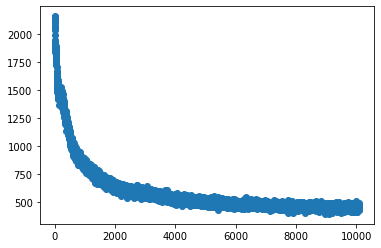

In [78]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

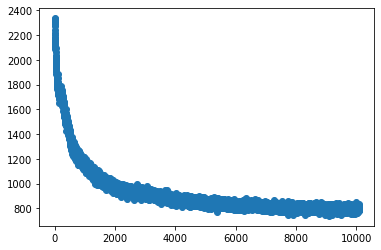

In [79]:
x=np.arange(len(n))
n=list(map(float, n))
plt.scatter(x,n)

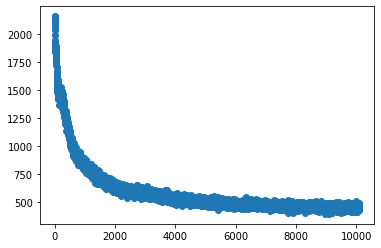

In [80]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

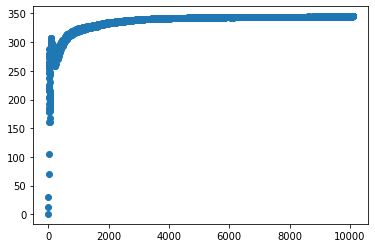

In [81]:
x=np.arange(len(k))
k=list(map(float, k))
plt.scatter(x,k)

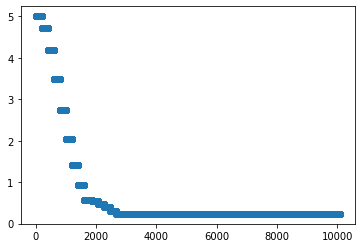

In [82]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [83]:
model.eval()

bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=5000, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=500, bias=True)
    (7): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=5000, bias=True)
    (7): Sigmoid()
  )
)

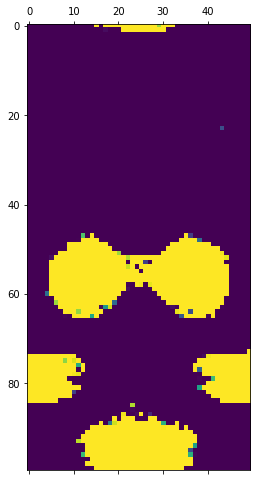

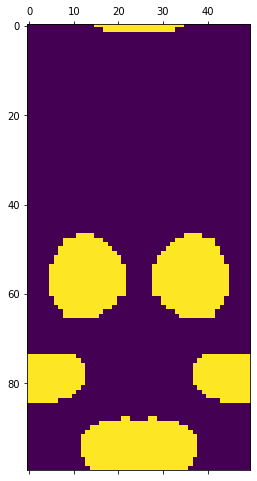

In [86]:
#a = torch.ones(5000)*0.1
#b=torch.bernoulli(a)
std=0.3

x=train_dataset2[np.random.randint(1000)]#*b.to(DEVICE)
#x=train_dataset2[444]

#x=train_dataset_val[111]#*b.to(DEVICE)
#x=train_dataset_val[np.random.randint(200)]#*b.to(DEVICE)

#x=torch.clamp(train_dataset2[np.random.randint(1000)]+torch.normal(0.0,std,(5000,)).to(DEVICE),0,1)

y=model(x.float().to(DEVICE))[0]
y=y.cpu().detach().numpy()
y=np.reshape(y,(100,50))
plt.matshow(y)

x1=x

x1=x1.cpu().detach().numpy()
x1=x1.reshape((100,50))
plt.matshow(x1)


0.08799913

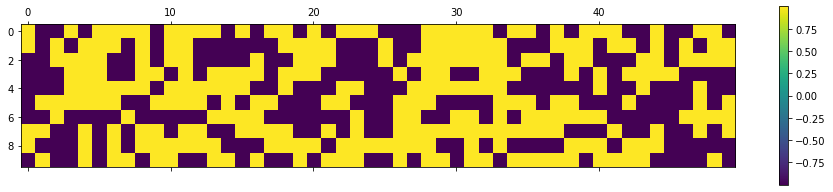

In [87]:
b=model(x.float().to(DEVICE))[1]
b=b.cpu().detach().numpy()
b=np.reshape(b,(10,50))
plt.matshow(b)
plt.colorbar()
np.average(b)

0.0879339

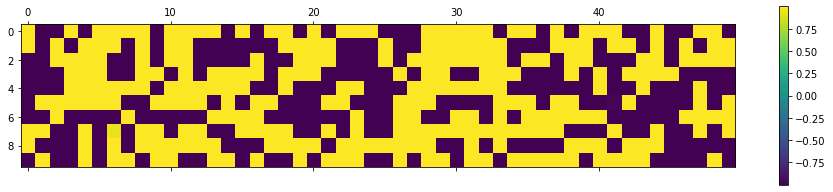

In [88]:
g=model(x.float().to(DEVICE))[2]
g=g.cpu().detach().numpy()
g=np.reshape(g,(10,50))
plt.matshow(g)
plt.colorbar()
np.average(g)

0.5435791

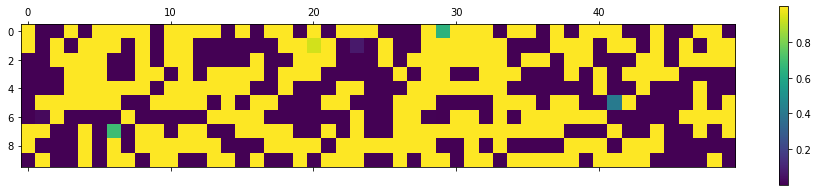

In [89]:
a=model(x.float().to(DEVICE))[3]
a=a.cpu().detach().numpy()
a=np.reshape(a,(10,50))
plt.matshow(a)
plt.colorbar()
np.average(a)#average pprobability

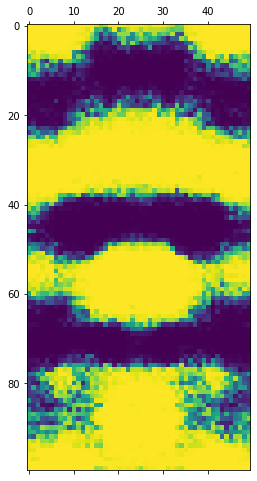

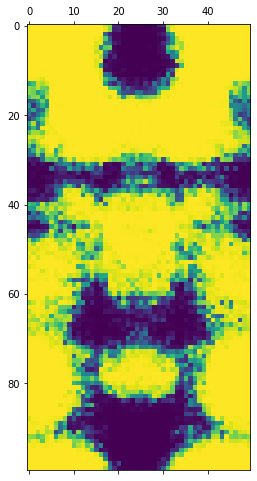

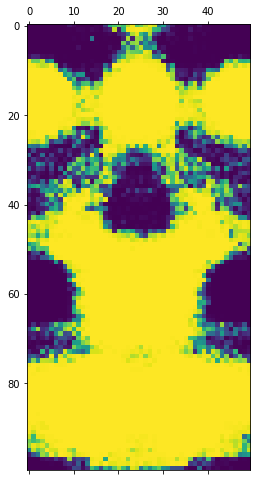

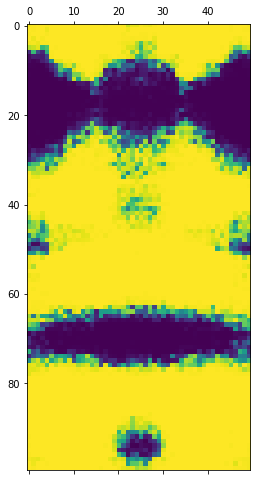

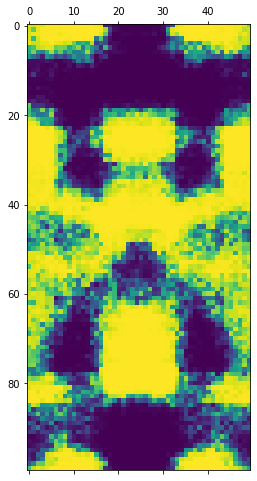

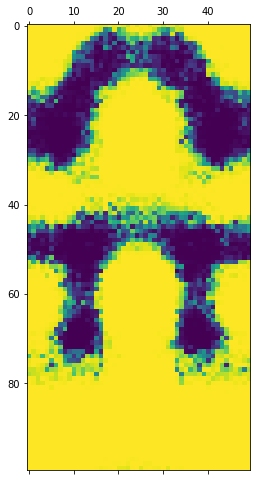

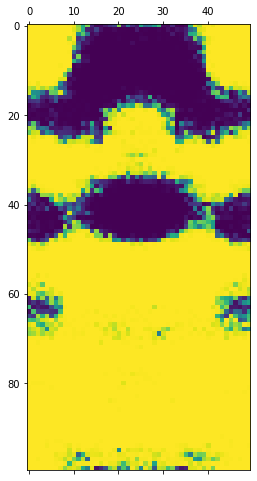

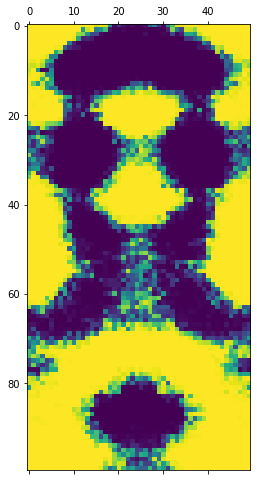

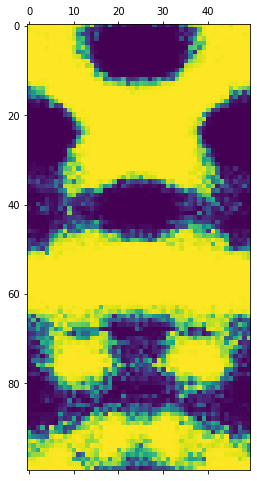

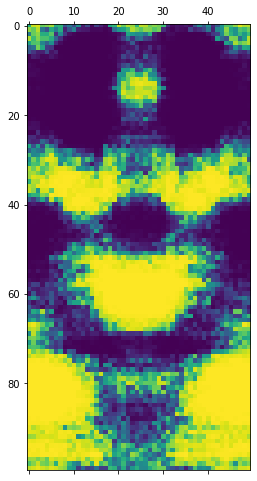

In [92]:
for i in range(10):
    a_check=torch.ones((latent_dim,))*0.5
    #a_check=torch.rand((latent_dim,))
    #decoder_input=model.gumbel_reparam(a_check,lambd)
    decoder_input=2*torch.bernoulli(a_check) .to(DEVICE)-1
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=np.reshape(output,(100,50))
    #output[output>0.5]=1
    #output[output<0.5]=0
    plt.matshow(output)
    #plt.matshow(ski.morphology.area_closing(output,area_threshold=50))

In [37]:
model(x.float().to(DEVICE))

(tensor([0.0025, 0.0025, 0.0034,  ..., 0.0048, 0.0032, 0.0020], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([ 1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000,
          1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
          1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000,
          1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,  1.0000,
          1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000,
         -1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000,  1.0000,
         -1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000, 

In [38]:
torch.save(model.state_dict(),'bVAE_state_dict_anneal_bce')

In [ ]:
torch.save(model, 'model_meta_anneal_bce')